# Exploração - studentVle

Esse notebook tem como objetivo realizar uma analise exploratória da tabela *studentVle* que é uma das mais importantes para entender o engajamento do aluno dentro do curso.

In [1]:
!pip install -qqq pandas_profiling

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from missingno import matrix

mpl.rcParams['figure.dpi'] = 200
sns.set_style("darkgrid")

In [2]:
arquivos = glob.glob("../../data/raw/*.csv")
arquivos

['../../data/raw/studentAssessment.csv',
 '../../data/raw/studentInfo.csv',
 '../../data/raw/studentVle.csv',
 '../../data/raw/courses.csv',
 '../../data/raw/vle.csv',
 '../../data/raw/studentRegistration.csv',
 '../../data/raw/assessments.csv']

In [3]:
data = {
    a.split('/')[-1][:-4]: pd.read_csv(a)
    for a in arquivos
}
data.keys()

dict_keys(['studentAssessment', 'studentInfo', 'studentVle', 'courses', 'vle', 'studentRegistration', 'assessments'])

## Modelo dos dados

![](../../images/model.png)

### Tabela *studentVle*

In [4]:
data['studentVle']

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


### Analise de valores faltantes

Não existem NaNs na tabela.

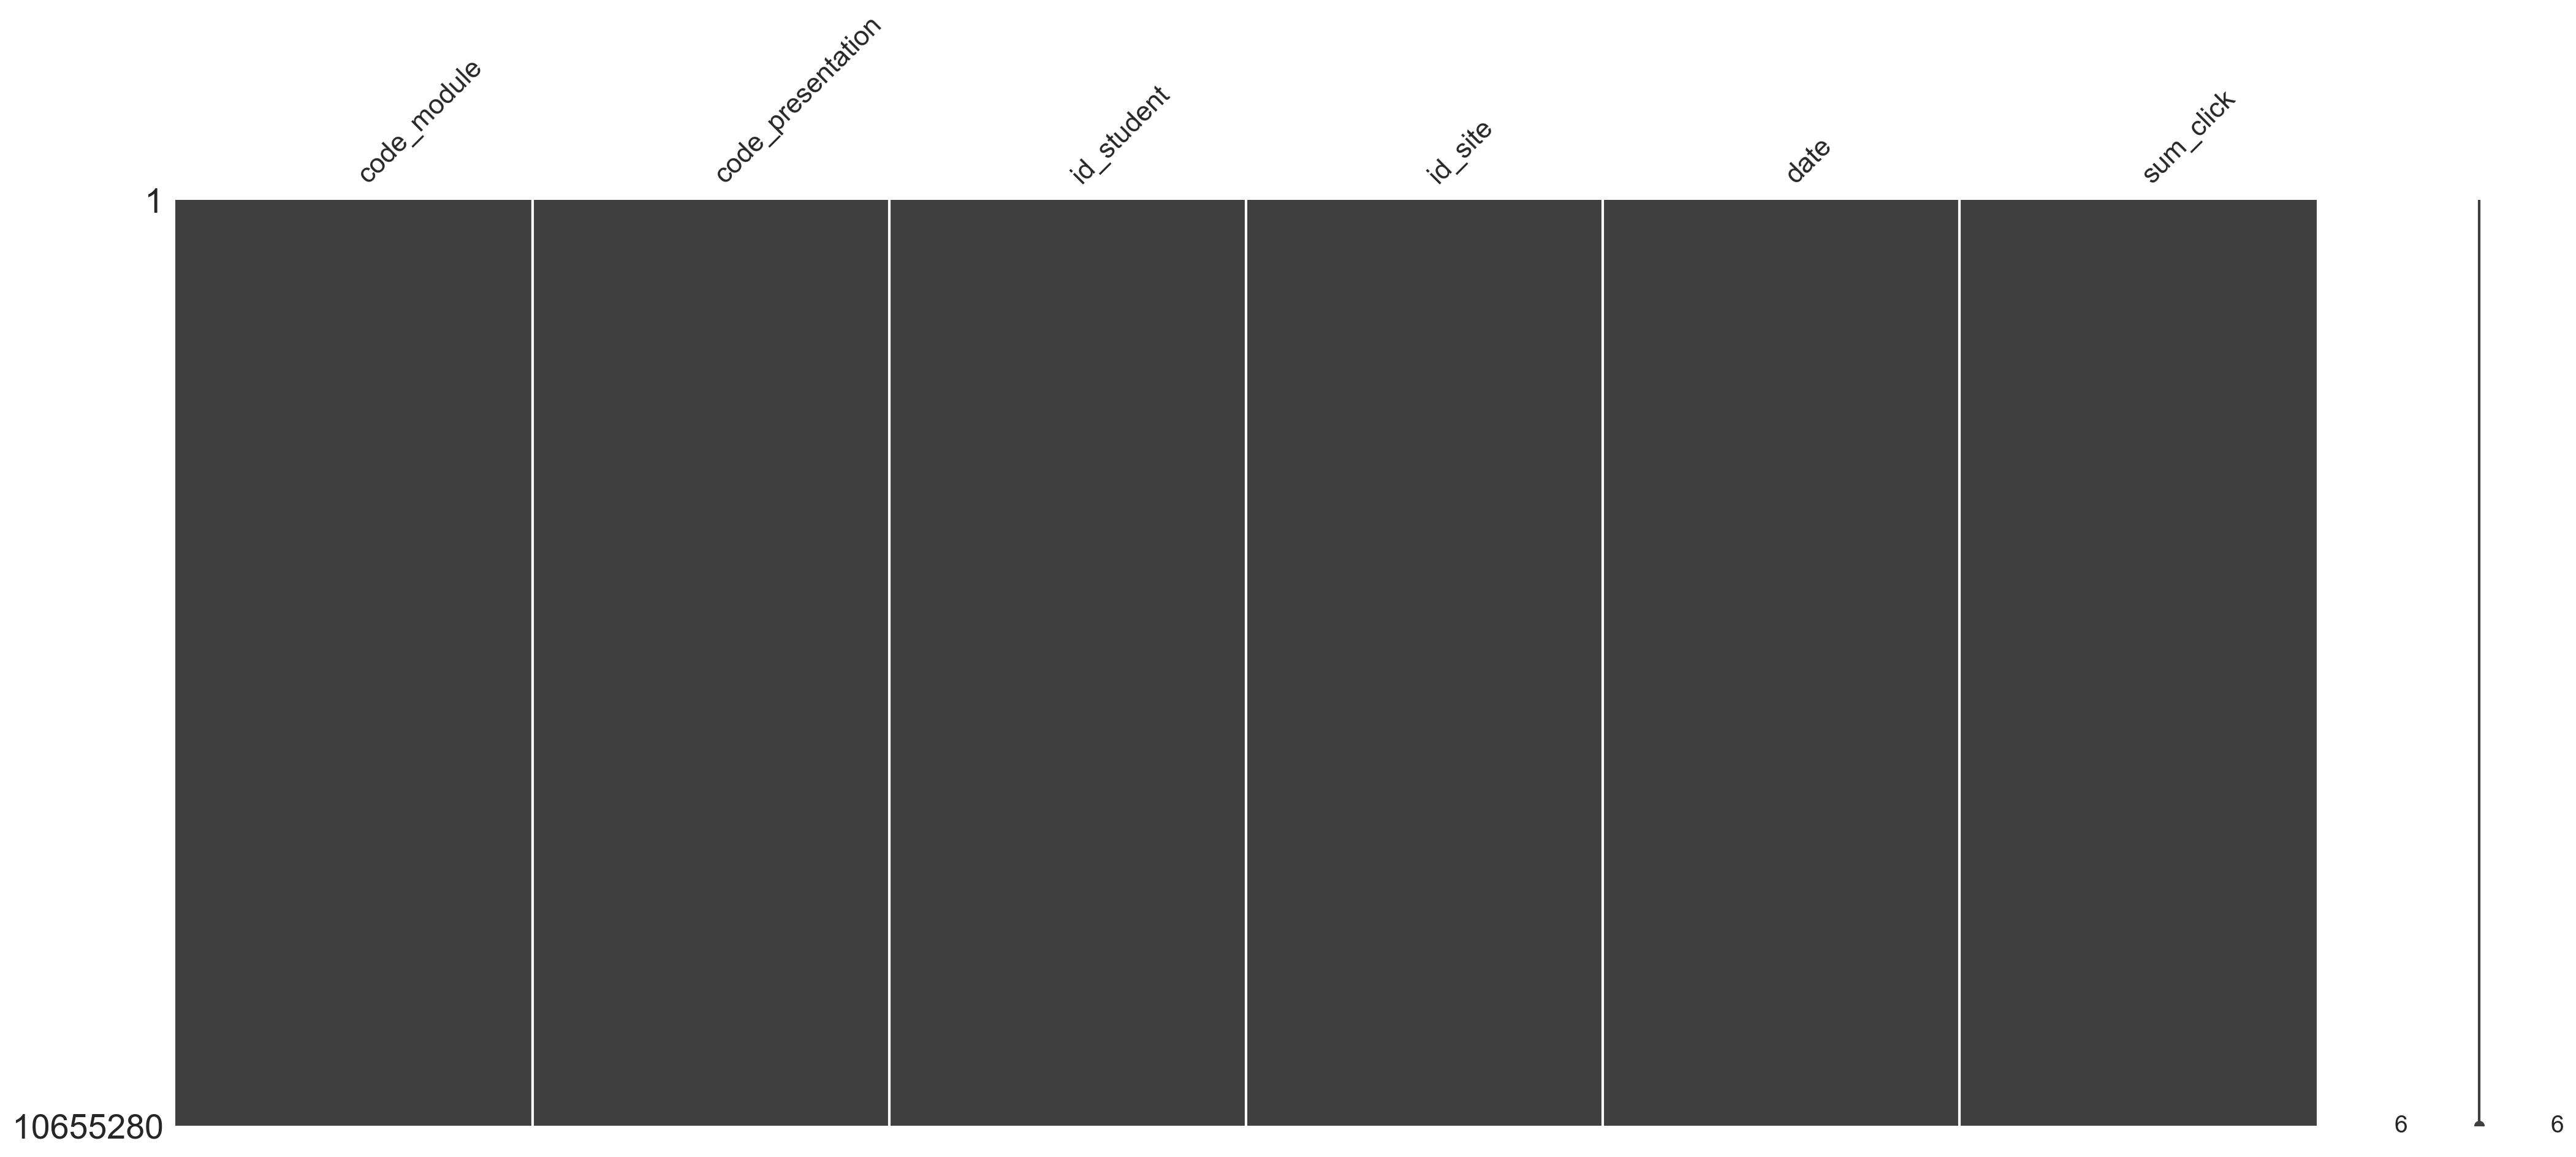

In [5]:
matrix(data['studentVle']);

In [6]:
data['studentVle'].describe()

,id_student,id_site,date,sum_click
count,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
mean,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00
max,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03


## Entradas individuais

Os campos *"code_module", "code_presentation", "id_student", "id_site", "date"* não possuem apenas uma entrada por combinação na tabela, ou seja, não formam uma chave primária composta. Isso implica que interações feitas pelo mesmo estudante, que está no mesmo modulo de uma mesma oferta, a um mesmo material, no mesmo dia, poderá gerar mais de uma linha caso o estudante entre duas vezes no mesmo material em horarios diferentes.

Para cruzar esses dados com a tabela *studentInfo* precisaremos utilizar os seguintes campos *"code_module", "code_presentation", "id_student"*. Para cada entrada da tabela *studentInfo* podem haver varias linhas na tabela *studentVle* contendo as varias interações que o estudante teve ao longo do curso.

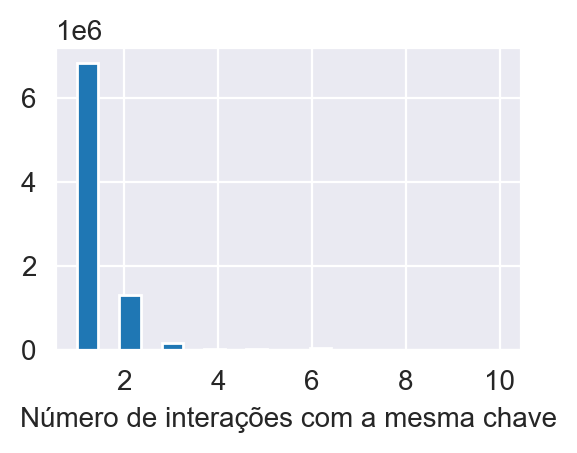

In [83]:
contagem = data['studentVle'].groupby(["code_module", "code_presentation", "id_student", "id_site", "date"]).count().sum_click
plt.figure(figsize=(3, 2))
plt.xlabel("Número de interações com a mesma chave")
contagem.hist(bins=20);

### Quantidade de clicks

Vemos que a grande maioria (99%+) das interações possui menos que 40 clicks (eixo x do gráfico truncado devido a presença de raras interações onde o aluno clicou mais de 1000 vezes na pagina).

In [64]:
print(f"Percentual de interações com mais de 40 clicks: {np.mean(data['studentVle'].sum_click > 40):.02}%")
print(f"Interação com mais clicks: {data['studentVle'].sum_click.max()} clicks")

Percentual de interações com mais de 40 clicks: 0.0074%
Interação com mais clicks: 6977 clicks


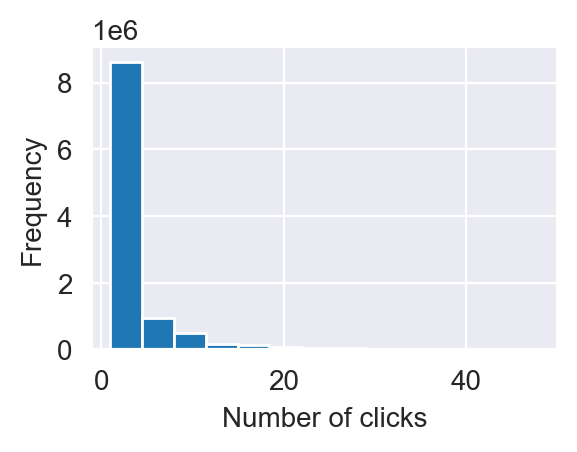

In [53]:
clicks = data['studentVle'].sum_click
plt.figure(figsize=(3, 2))
plt.xlim([-1, 50])
clicks.plot.hist(bins=2000)
plt.xlabel("Number of clicks");

### Data de inicio (relativa ao inicio do curso)

Vemos que a data de interação com os materiais se extende por todo o periodo dos cursos, com maior peso nos primeiros 50 dias (o que pode ser causado tanto por uma maior empolgação dos estudantes com o inicio do curso, ou apenas pela presença de cursos com menor duração).

Um ponto de destaque é a existencia de interações com o material antes mesmo do curso se iniciar.

In [67]:
print(f"Primeira interação com o material antes do incio das aulas: {abs(data['studentVle'].date.min())} dias antes do inicio")

Primeira interação com o material antes do incio das aulas: 25 dias antes do inicio


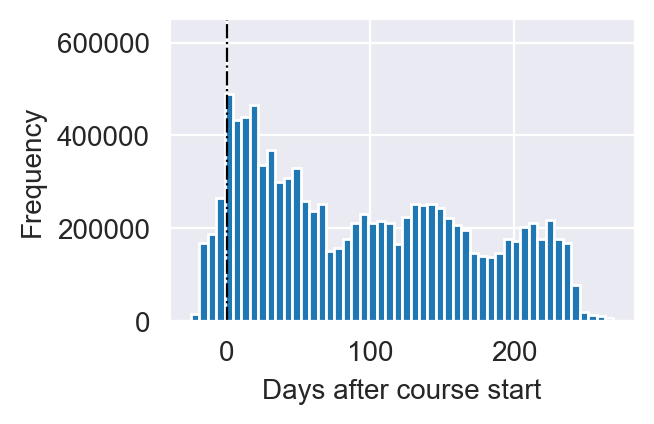

In [81]:
days = data['studentVle'].date
plt.figure(figsize=(3, 2))
days.plot.hist(bins=50)
plt.ylim([-10, 650000])
plt.vlines(0, ymin=0, ymax=650000, linestyles='dashdot', linewidths=0.8)
plt.xlabel("Days after course start");

## Profiling automatizado

Executando profiling automatizado para verificar algum outro detalhe que possa ter passado batido.

In [19]:
from pandas_profiling import ProfileReport

ProfileReport(data['studentVle'])